In [1]:
!pip install transformers

In [2]:
!pip install tape_proteins

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 7.8 MB/s eta 0:00:00


In [3]:
!pip install pandas
import pandas as pd
train_df = pd.read_csv("data.csv", header=0)
train_df_bert = train_df
train_sentences = train_df_bert.Sequence.values
train_labels = train_df_bert.Label.values

In [4]:
!pip install numpy

In [6]:
!pip install tensorflow
!pip install pytorch_lightning
!pip install SentencePiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.2 MB/s eta 0:00:00


In [8]:
import torch
import pandas as pd
import numpy as np
from tape import ProteinBertModel, TAPETokenizer
from sklearn.model_selection import train_test_split

# Load your CSV file
file_path = 'data.csv'  # Replace with the actual file path
df = pd.read_csv(file_path)

# Assuming 'Sequence' is the column containing protein sequences, and 'Label' is the target column
X = df['Sequence']
y = df['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model and tokenizer
model = ProteinBertModel.from_pretrained('bert-base')
tokenizer = TAPETokenizer(vocab='iupac')
w = 32  # Adjust the window size as needed
X_train_ds = []

# Embedding process for training data
for i in range(X_train.shape[0]):
    # Tokenize the protein sequence
    token_id = torch.tensor([tokenizer.encode(X_train.iloc[i])])

    # Get word embeddings from the model
    output = model(token_id)[0]
    word_embeddings = output[0][1:2 * w + 2].detach().numpy()

    # Append the word embeddings to the list
    X_train_ds.append(word_embeddings)

# Stack and reorganize the data
X_train_ds = np.dstack(X_train_ds)
X_train_ds = np.rollaxis(X_train_ds, -1)

# Display the resulting word embeddings for training data
print(X_train_ds)



[[[-6.4364952e-01 -1.7254419e+00  1.0808032e+00 ...  5.8686352e-01
    5.7147640e-01 -9.0267473e-01]
  [-3.3305570e-01 -1.6078819e+00  9.1328192e-01 ... -7.1375579e-01
    1.7199039e+00 -6.3036579e-01]
  [-5.8058661e-01 -6.9997376e-01  1.3243484e+00 ...  4.4273776e-01
   -5.2244312e-01 -2.3011816e+00]
  ...
  [-6.8090367e-01 -1.0790181e+00 -6.3704360e-01 ... -3.6899993e-01
   -9.7457492e-01 -1.4437270e+00]
  [ 1.2697263e+00 -1.0271461e+00  4.5026171e-01 ...  2.3314101e-01
   -4.5416301e-01 -5.4621959e-01]
  [-1.4097834e-01 -3.1023085e-01 -6.5230143e-01 ...  3.8147202e-01
   -1.4577290e+00 -6.9204873e-01]]

 [[ 3.4658790e-01 -1.1432242e+00  9.5442033e-01 ... -9.4865352e-02
   -4.7060716e-01 -2.3859386e+00]
  [ 4.8964840e-01 -1.1985205e+00  8.2546395e-01 ... -5.3226745e-01
   -3.6134529e-01 -2.2594922e+00]
  [ 2.1195656e-01 -1.9406472e+00  8.2091987e-02 ... -1.2683886e+00
    2.0416902e-01 -1.2567284e+00]
  ...
  [ 1.2838854e-01 -1.2547132e+00 -9.1287589e-01 ...  5.6080985e-01
    5.1255

In [11]:
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import os
import logging
from configparser import ConfigParser

logger = logging.getLogger(__name__)

def CNNWithBiLSTMModel(X_train, Y_train, X_valid, Y_valid, embedding_input_shape, config_file='CNN_config.ini'):
    # Load configuration from the specified INI file
    parser = ConfigParser(os.environ)
    if not os.path.exists(config_file):
        raise IOError("Configuration file '%s' does not exist" % config_file)
    logging.info('Loading config from %s', config_file)
    parser.read(config_file)
    config_header = 'CNN'

    logger.info('config header: %s', config_header)

    # Retrieve hyperparameters from the configuration file
    filters = parser.getint(config_header, 'filters')
    kernels = parser.getint(config_header, 'kernels')
    dense_layers1 = parser.getint(config_header, 'dense_layers1')
    dense_layers2 = parser.getint(config_header, 'dense_layers2')
    Learning_Rate = parser.getfloat(config_header, 'Learning_Rate')
    dropout = parser.getfloat(config_header, 'dropout')
    Batch_size = parser.getint(config_header, 'Batch_size')
    Epochs = parser.getint(config_header, 'Epochs')
    earlystop = parser.getboolean(config_header, 'earlystop')

    # Define the model input shape based on the protein embeddings
    inputs = keras.Input(shape=embedding_input_shape, dtype="float32")

    # Add Bidirectional LSTM layer
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(inputs)

    # Add CNN layers
    x = layers.Conv1D(filters, kernel_size=kernels, padding='same')(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    x = layers.Flatten()(x)

    # Add Dense layers
    x = layers.Dense(dense_layers1, activation='relu')(x)
    x = layers.Dense(dense_layers2, kernel_regularizer=keras.regularizers.l2(0.001),
                     activity_regularizer=keras.regularizers.l1(0.001))(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout)(x)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create and compile the model
    kmodel = keras.Model(inputs, outputs)
    opt = keras.optimizers.Adam(learning_rate=Learning_Rate)
    kmodel.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=opt)

    # Define early stopping callback
    callback1 = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0005, patience=8, restore_best_weights=True)

    # Train the model
    if earlystop:
        kmodel.fit(X_train, Y_train, batch_size=Batch_size, epochs=Epochs, validation_data=(X_valid, Y_valid),
                   callbacks=[callback1])
    else:
        kmodel.fit(X_train, Y_train, batch_size=Batch_size, epochs=Epochs, validation_data=(X_valid, Y_valid))

    return kmodel

# Modify the input shape based on the dimensions of your protein embeddings
model_input_shape = X_train_ds.shape[1:]

# Call your CNNWithBiLSTMModel function
model = CNNWithBiLSTMModel(X_train_ds, y_train, X_train_ds, y_train, embedding_input_shape=model_input_shape)
model.save('BertCNNWithBiLSTM.h5')


Epoch 1/100
94/94 [==============================] - 12s 63ms/step - loss: 0.7429 - accuracy: 0.5760 - val_loss: 0.7073 - val_accuracy: 0.6202
Epoch 2/100
94/94 [==============================] - 2s 20ms/step - loss: 0.6679 - accuracy: 0.6522 - val_loss: 0.6303 - val_accuracy: 0.6915
Epoch 3/100
94/94 [==============================] - 2s 21ms/step - loss: 0.6124 - accuracy: 0.6895 - val_loss: 0.5996 - val_accuracy: 0.6474
Epoch 4/100
94/94 [==============================] - 2s 21ms/step - loss: 0.5664 - accuracy: 0.7227 - val_loss: 0.4871 - val_accuracy: 0.7990
Epoch 5/100
94/94 [==============================] - 3s 27ms/step - loss: 0.4933 - accuracy: 0.7782 - val_loss: 0.4033 - val_accuracy: 0.8385
Epoch 6/100
94/94 [==============================] - 3s 30ms/step - loss: 0.4096 - accuracy: 0.8256 - val_loss: 0.3121 - val_accuracy: 0.8774
Epoch 7/100
94/94 [==============================] - 2s 21ms/step - loss: 0.3374 - accuracy: 0.8585 - val_loss: 0.2511 - val_accuracy: 0.9039
Epoch

In [12]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Assuming you already have the trained model 'model' and test data 'X_test_ds'
# Initialize the model and tokenizer
model = ProteinBertModel.from_pretrained('bert-base')
tokenizer = TAPETokenizer(vocab='iupac')
w = 32  # Adjust the window size as needed

# Tokenize and embed the test data
X_test_ds = []
for i in range(X_test.shape[0]):
    token_id = torch.tensor([tokenizer.encode(X_test.iloc[i])])
    output = model(token_id)[0]
    word_embeddings = output[0][1:2 * w + 2].detach().numpy()
    X_test_ds.append(word_embeddings)

# Stack and reorganize the data
X_test_ds = np.dstack(X_test_ds)
X_test_ds = np.rollaxis(X_test_ds, -1)




In [13]:
from keras.models import load_model
model = load_model('BertCNNWithBiLSTM.h5')
# Predict on the test data
y_pred = model.predict(X_test_ds)

# Convert the probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)

# Calculate accuracy
acc = accuracy_score(y_test, y_pred_binary)

# Print the results
print(f'AUC: {auc}')
print(f'Accuracy: {acc}')

47/47 [==============================] - 1s 7ms/step
AUC: 0.6911023559776552
Accuracy: 0.6487935656836461


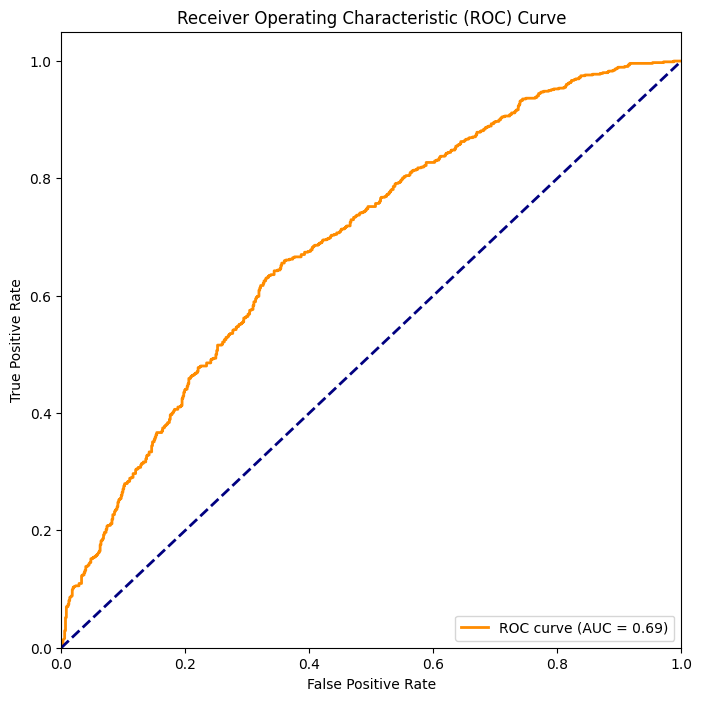

AUC: 0.6911023559776552
Accuracy: 0.6487935656836461


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you already have the true labels 'y_test' and predicted probabilities 'y_pred'
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Display AUC and accuracy values
print(f'AUC: {roc_auc}')
print(f'Accuracy: {acc}')
